## Import libraries

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import cv2
from tqdm import tqdm

from keras.models import Model
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler



In [2]:
Data_path ='/kaggle/input/diamond-images-dataset/web_scraped'
labels =['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']

cushion : Class number 0 , that contain 5341 image


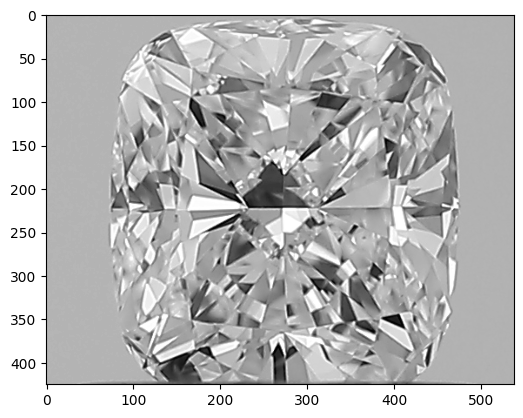

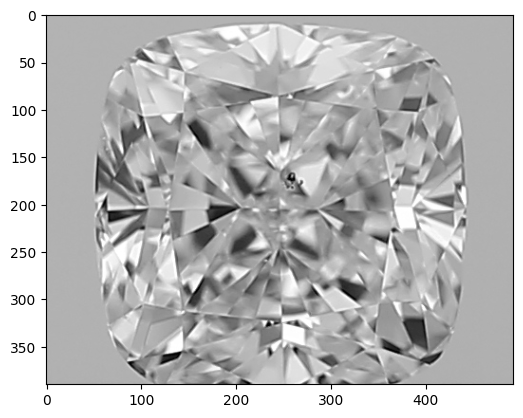

emerald : Class number 1 , that contain 3392 image


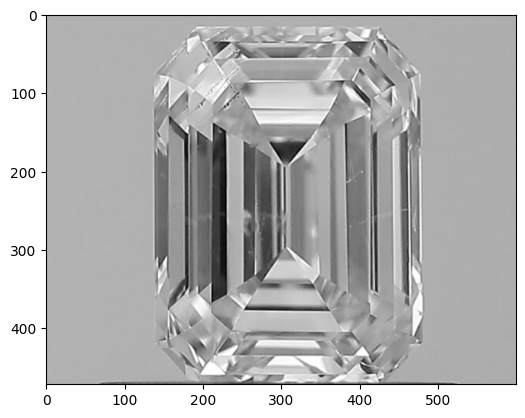

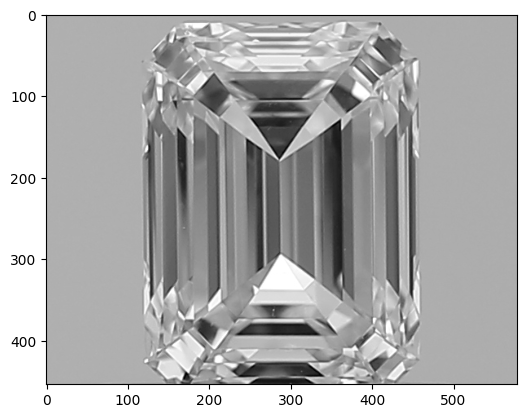

heart : Class number 2 , that contain 3756 image


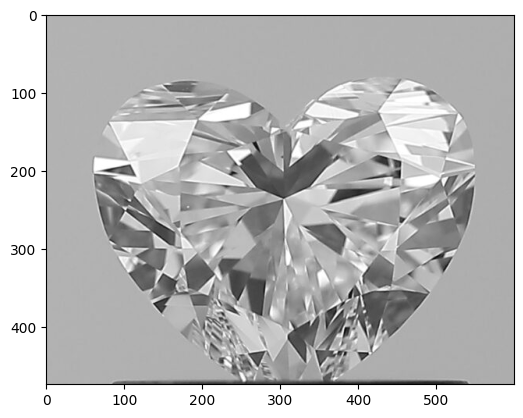

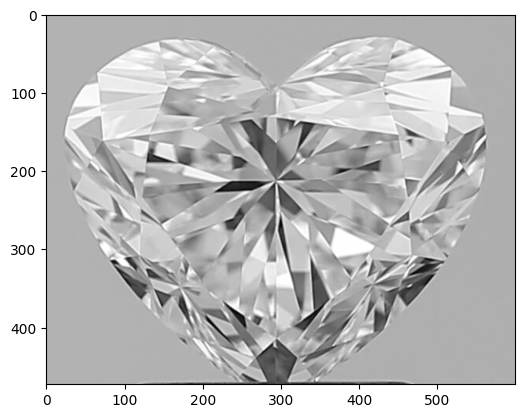

marquise : Class number 3 , that contain 465 image


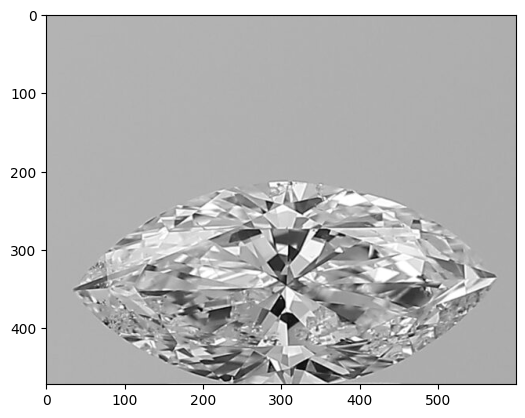

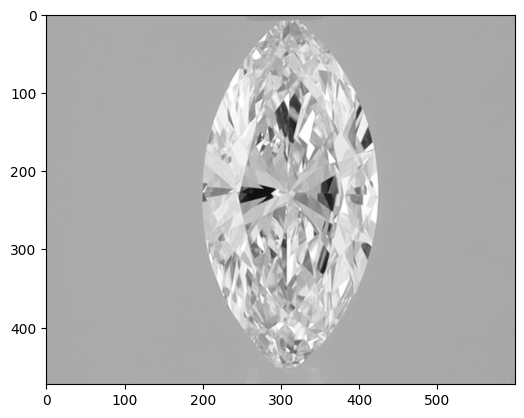

oval : Class number 4 , that contain 6492 image


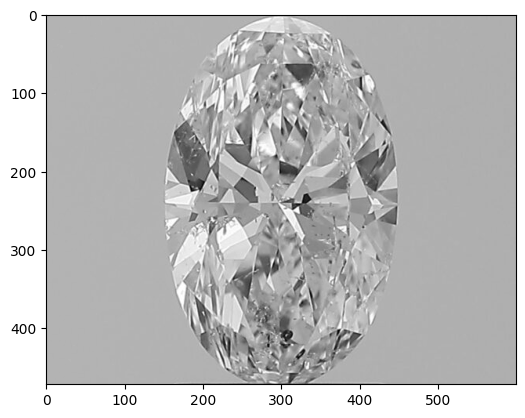

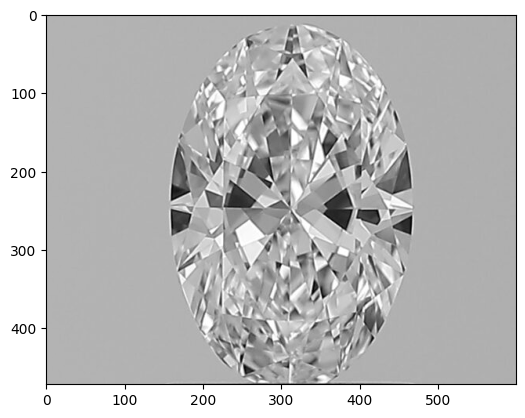

pear : Class number 5 , that contain 4338 image


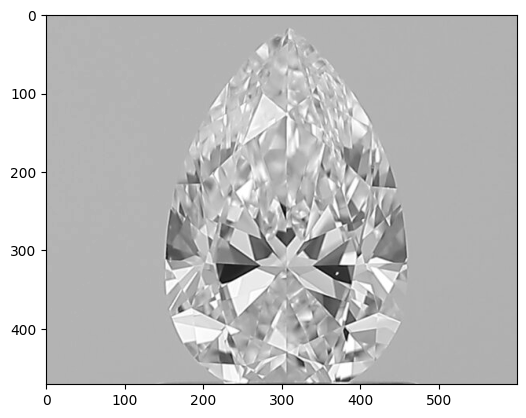

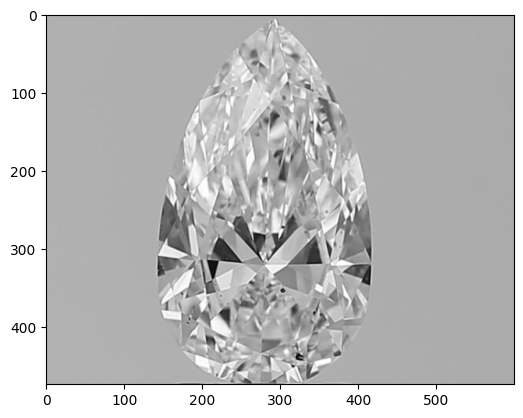

princess : Class number 6 , that contain 3949 image


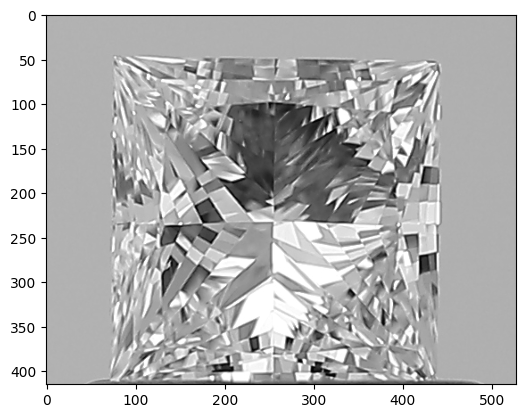

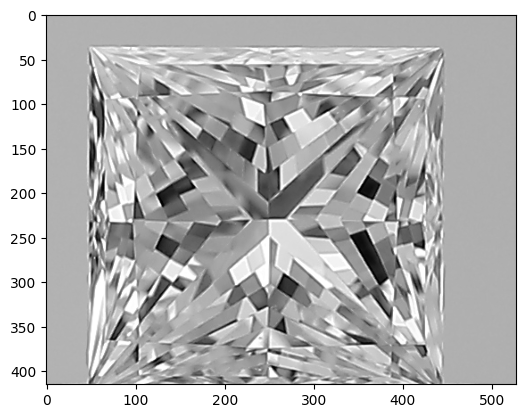

round : Class number 7 , that contain 21032 image


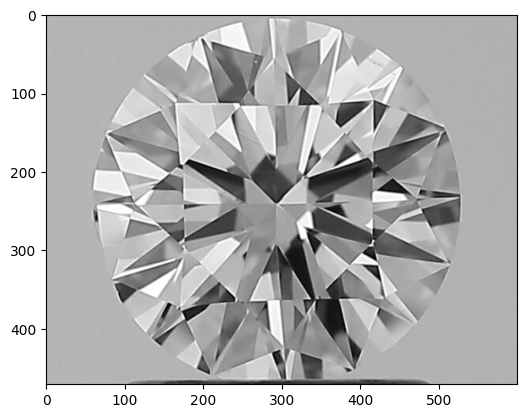

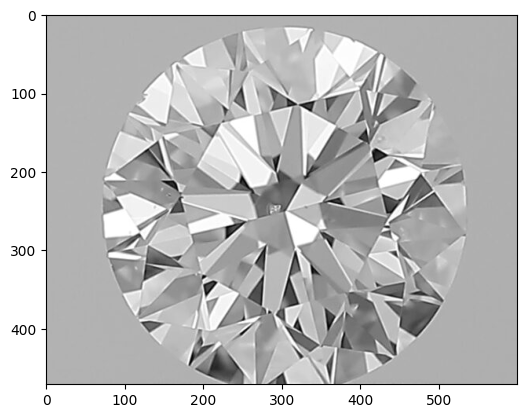

In [3]:
i =0
counts = {}

for label in labels :
    path =os.path.join(Data_path ,label)
    counts[label] = len(os.listdir(path))
    x =0
    print(f'{label} : Class number {i} , that contain {len(os.listdir(path))} image')
    for img in os.listdir(path):
        x +=1
        img =cv2.imread(os.path.join(path ,img) ,cv2.IMREAD_GRAYSCALE)
        plt.imshow(img ,cmap ='gray')
        plt.show()
        if x ==2 :
            print('==='*40)
            break
    i +=1

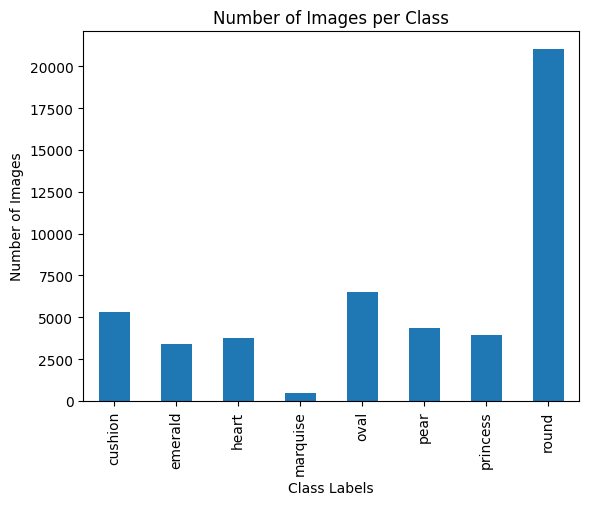

In [4]:
df = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])
df.set_index('Label', inplace=True)

df.plot(kind='bar', legend=False)

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [5]:
img.shape

(471, 600)

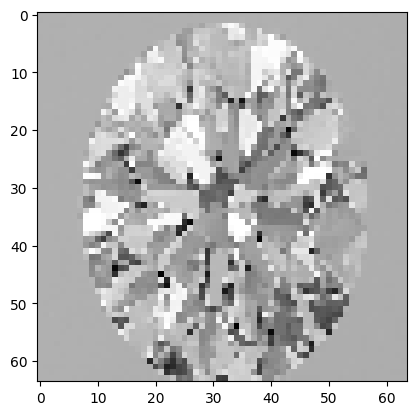

In [47]:
img_size =64

resized_img =cv2.resize(img ,(img_size ,img_size) ,1)
plt.imshow(resized_img ,cmap ='gray')
plt.show()

In [48]:
Data = []

def creat_df(in_path, data):
    for label in labels:
        path = os.path.join(in_path, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img = img / 255.0
                resized_img = cv2.resize(img, (img_size, img_size))
                data.append(resized_img)
            except Exception as e:  
                pass  
                               
# Call the function
creat_df(Data_path, Data)

100%|██████████| 21032/21032 [01:19<00:00, 263.05it/s]


In [75]:
import random

random.shuffle(Data)

In [76]:
l =len(Data)
print(l * .8)

39011.200000000004


In [77]:
X_train = Data[:int(l * .8)]
X_test =  Data[int(l * .8):]

print(len(X_train))
print(len(X_test))

39011
9753


In [78]:
X_train = np.array(X_train).reshape(-1, img_size, img_size, 1).astype('float32')
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1).astype('float32')
X_train.shape

(39011, 64, 64, 1)

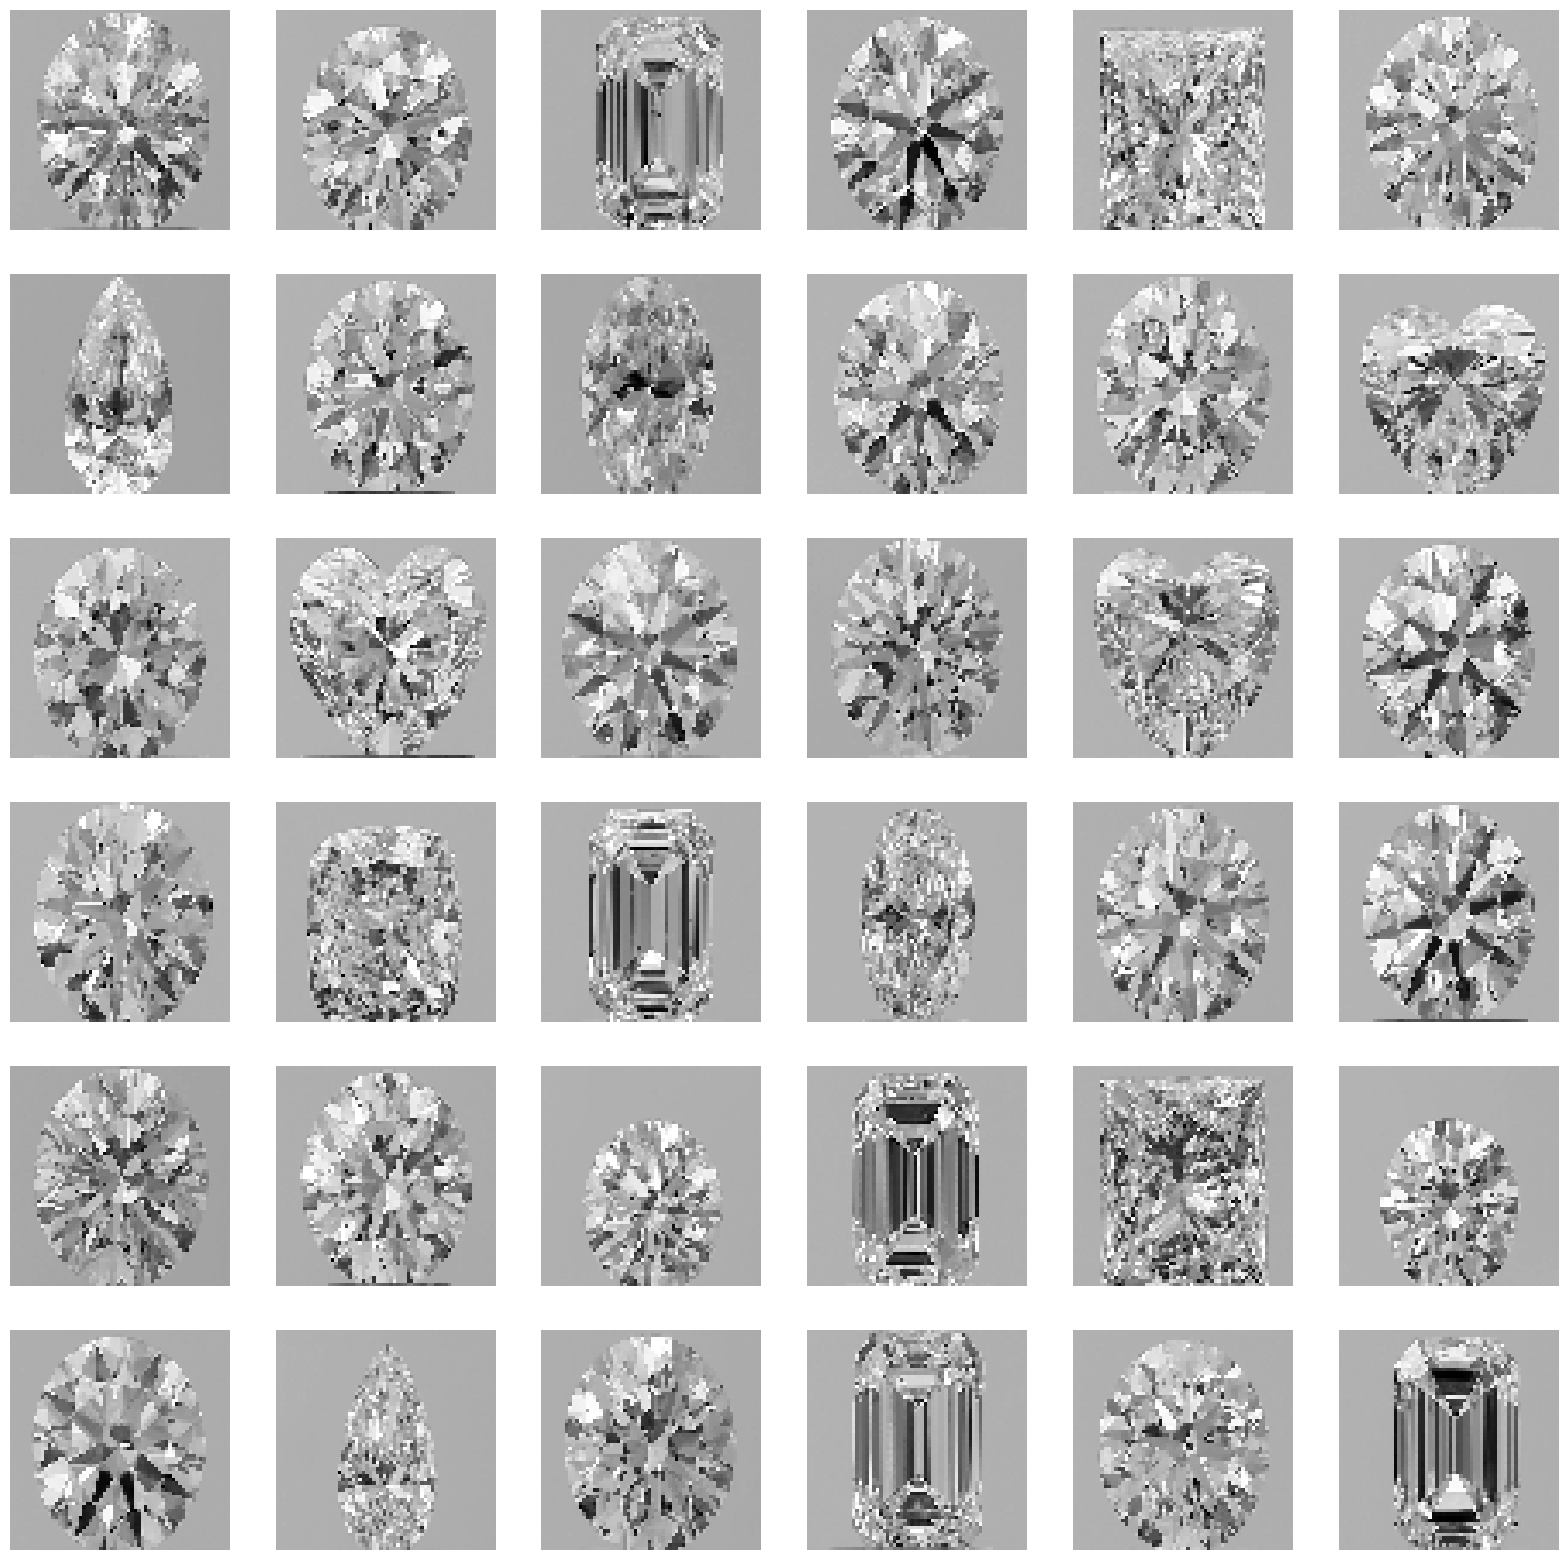

In [79]:
plt.figure(figsize=(20,20))

for n , i in enumerate(np.random.randint(0,len(X_train),36)) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i] ,cmap ='gray')
    plt.axis('off')


## Model

* **Encoder**

In [80]:
input_shape = (img_size, img_size, 1)  # Grayscale images

# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Reduce spatial size
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Reduce spatial size
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Further reduce spatial size


* **Decoder**

In [82]:

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to original size
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to original size
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsample to original size


decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)  # 1 channel for grayscale output

* **AutoEncoder**

In [83]:

# Define the autoencoder model
autoencoder = Model(inputs, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Model summary
autoencoder.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ (None, 8, 8, 128)           │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_27 (UpSampling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_34                  │ (None, 16, 16, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_28 (UpSampling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_35                  │ (None, 32, 32, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_29 (UpSampling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_36                  │ (None, 64, 64, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32)

Epoch 1/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.6223
Epoch 2/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6092
Epoch 3/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6070
Epoch 4/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6053
Epoch 5/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6046
Epoch 6/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6036
Epoch 7/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6030
Epoch 8/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6025
Epoch 9/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6020
Epoch 10/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6017
Epoch 11/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6013
Epoch 12/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6011
Epoch 13/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6008
Epoch 14/50
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6006
Epoch 15/50
1220/1220 ━━━━━━

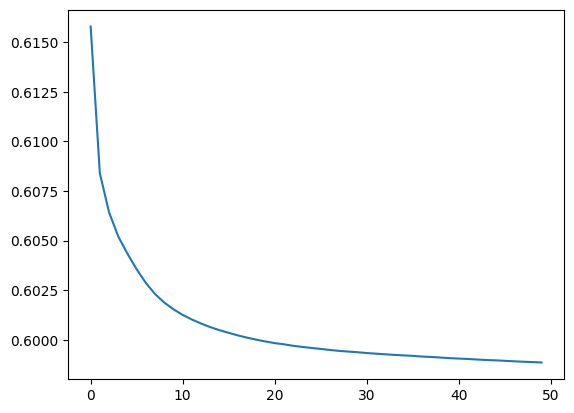

In [85]:
plt.plot(history.history['loss'])

In [92]:
autoencoder.save('autoencoder_model.h5')

## Prediction

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


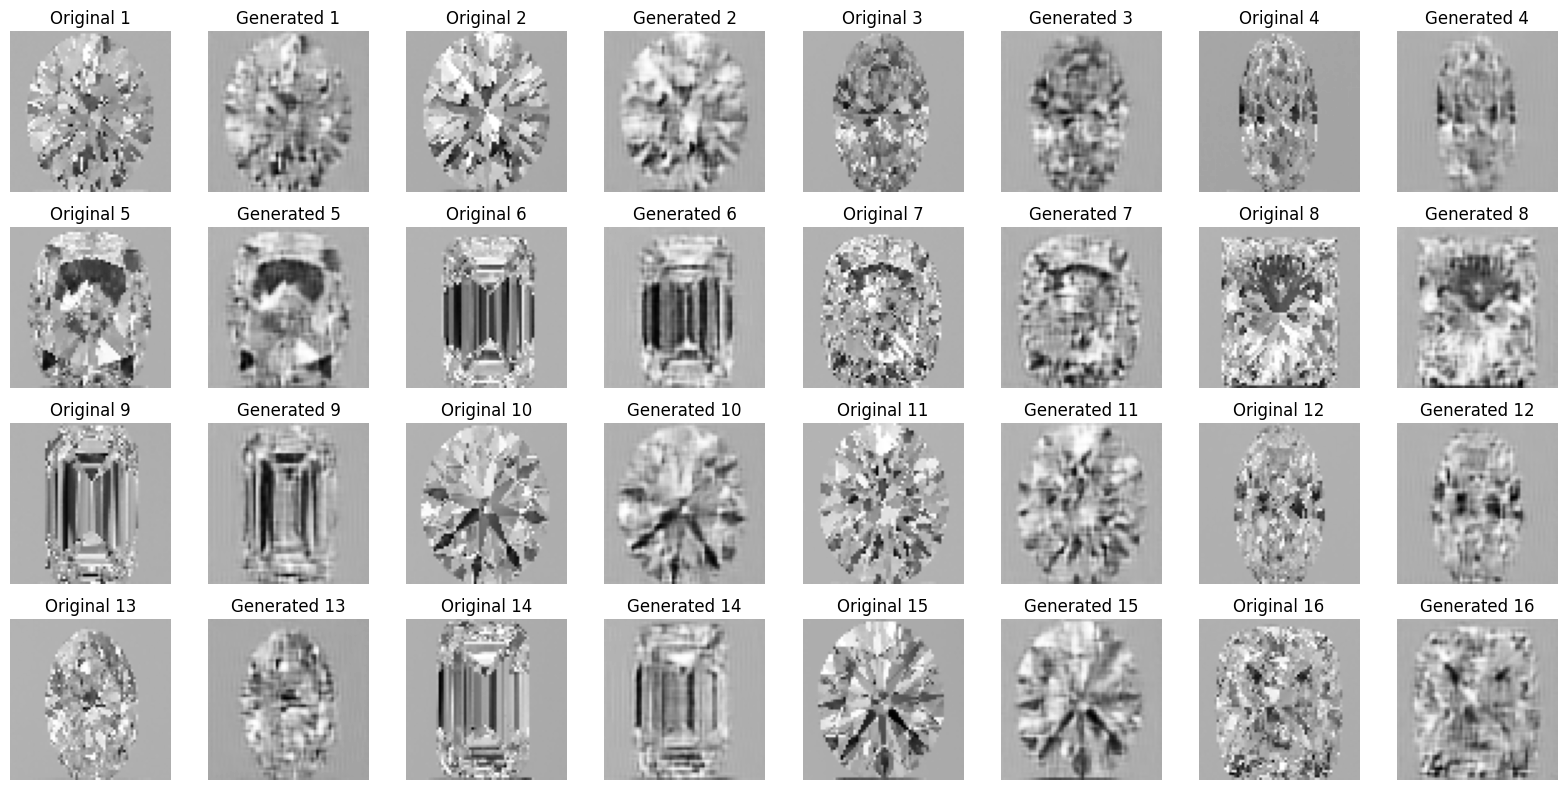

In [91]:
generated_img = autoencoder.predict(X_test)

# Create a 4x8 grid of subplots
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

# Loop through the first 16 images
for i in range(16):
    # Display the original image (left side of the pair)
    axes[i // 4, 2 * (i % 4)].imshow(X_test[i].squeeze(), cmap='gray')
    axes[i // 4, 2 * (i % 4)].axis('off')
    axes[i // 4, 2 * (i % 4)].set_title(f"Original {i + 1}")
    
    # Display the generated (reconstructed) image (right side of the pair)
    axes[i // 4, 2 * (i % 4) + 1].imshow(generated_img[i].squeeze(), cmap='gray')
    axes[i // 4, 2 * (i % 4) + 1].axis('off')
    axes[i // 4, 2 * (i % 4) + 1].set_title(f"Generated {i + 1}")

plt.tight_layout()
plt.show()